In [1]:
from osgeo import gdal,gdal_array
import os,sys,tempfile
from math import sqrt
import pandas as pd
import numpy as np
from qgis.PyQt.QtCore import QVariant
from qgis import processing
#import processing
from qgis.core import QgsVectorLayer,QgsField,QgsFeature,edit,QgsApplication,QgsVectorFileWriter,QgsCoordinateTransform,QgsRasterLayer
from qgis.analysis import QgsInterpolator,QgsIDWInterpolator,QgsGridFileWriter
from getInput import getBboxWmsFormat

#for developing
QgsApplication.setPrefixPath(QgsApplication.prefixPath(), True)
qgs = QgsApplication([], False)
qgs.initQgis()
sys.path.append(os.path.join(QgsApplication.prefixPath(),"python\plugins"))
import processing
from processing.core.Processing import Processing
Processing.initialize()
from qgis.analysis import QgsNativeAlgorithms


import geopandas as gpd
import rasterio
from rasterio.plot import show

In [5]:
#example weblayers
#chm = 'https://rajapinnat.metsaan.fi/geoserver/Avoinmetsatieto/CHM_newest/ows?
chm = QgsRasterLayer(r'P:\Aineistot\test_mjk\aineistot\uusinCHM.vrt',"raster","gdal")
clip = QgsVectorLayer(r'C:/git/smk_tools/processing/data_example/ReTreeT.gpkg|layername=cuttingarea',"vector","ogr")
dtw_qgis = QgsRasterLayer('dpiMode=7&identifier=paituli:luke_dtw_04&url=https://paituli.csc.fi/geoserver/paituli/wcs&http-header:referer=','dtw','wcs')
output_clip = r'C:\git\smk_tools\processing\data_example\output\clip_test.tif'

<>:2: DeprecationWarning: invalid escape sequence \R
<>:3: DeprecationWarning: invalid escape sequence \R
<>:2: DeprecationWarning: invalid escape sequence \R
<>:3: DeprecationWarning: invalid escape sequence \R
C:\Users\mkesala\AppData\Local\Temp\ipykernel_15628\2630253212.py:2: DeprecationWarning: invalid escape sequence \R
  data_example = "data_example\ReTreeT.gpkg"
C:\Users\mkesala\AppData\Local\Temp\ipykernel_15628\2630253212.py:3: DeprecationWarning: invalid escape sequence \R
  data_alueet = "data_example\ReTreeT.gpkg|layername=alueet"


('593158,6961947,593317,6962175', 'EPSG:3067', 159, 228)


<AxesSubplot:>

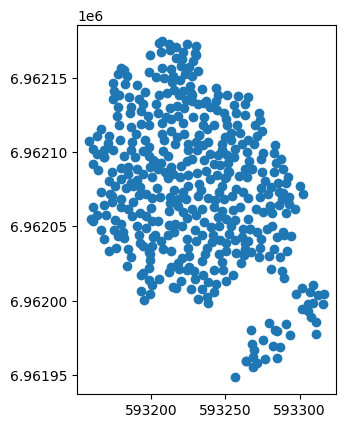

In [11]:
#example cutting area
data_example = "data_example\ReTreeT.gpkg"
data_alueet = "data_example\ReTreeT.gpkg|layername=alueet"
layer = "treemap"
data_qgis = QgsVectorLayer(data_example+"|layername="+layer,"cutarea","ogr")
data_df = gpd.read_file(data_example,layer = layer)

#data_df
bb = getBboxWmsFormat(data_qgis)
print (bb)

data_df.plot()

In [27]:
l = [str(f.name()) for f in data_qgis.fields()]
print (l)

['fid', 'CHM', 'SPECIALFEATURECODE', 'SPECIALFEATUREADDITIONALCODE', 'FERTILITYCLASS', 'DEVELOPMENTCLASS', 'STEMCOUNTPINE', 'STEMCOUNTDECIDUOUS', 'STEMCOUNTSPRUCE', 'MEANDIAMETERDECIDUOUS', 'MEANDIAMETERPINE', 'MEANDIAMETERSPRUCE', 'MEANHEIGHTDECIDUOUS', 'MEANHEIGHTPINE', 'MEANHEIGHTSPRUCE', 'PaajakoNro', 'Nimi', 'Nimi_2', 'leimikko', 'DTW_1', 'euc_1', 'DTW_1n', 'biod', 'biodn', 'dtree', 'dtreen', 'pRetent', 'pRetentn', 'env_value', 'reTree', 'trees', 'diameter']


In [19]:
#outraster = "C:\\git\\smk_tools\\processing\\data_example\\output\\out_raster.tif"
def clipRaster2(input_raster,clip_vector):
    xsize =  int(round(chm.rasterUnitsPerPixelX(),0))
    ysize = int(round(chm.rasterUnitsPerPixelY(),0))

    #print (chm.name())
    input_raster.name()
    alg_params = {
                'BURN': 1,
                'DATA_TYPE': 5,  # Float32
                'EXTENT': None,
                'EXTRA': '',
                'FIELD': '',
                'HEIGHT': 1,
                'INIT': None,
                'INPUT': clip_vector,
                'INVERT': False,
                'NODATA': 0,
                'OPTIONS': '',
                'UNITS': 0,  # Soluina (pikseleinä)
                'USE_Z': False,
                'WIDTH': 1,
                'OUTPUT':'TEMPORARY_OUTPUT'}

    raster_extent = processing.run('gdal:rasterize', alg_params)
    raster_extent = raster_extent['OUTPUT']

    alg_params = {
                'CELLSIZE': xsize,
                'CRS': None,
                'EXPRESSION':input_raster.name()+"@1",
                'EXTENT': raster_extent,
                'LAYERS': raster_extent,
                'OUTPUT': 'TEMPORARY_OUTPUT'}

    raster_clip = processing.run('qgis:rastercalculator', alg_params)
    return raster_clip

In [20]:
test = clipRaster2(chm,clip)

QgsProcessingException: An error occurred while performing the calculation

In [3]:
def copyVector(layer):
    
    feats = [feat for feat in layer.getFeatures()]
    crs = str(layer.crs().authid())
    mem_layer = QgsVectorLayer("Point?crs="+crs, "copy", "memory")

    mem_layer_data = mem_layer.dataProvider()
    attr = layer.dataProvider().fields().toList()
    mem_layer_data.addAttributes(attr)
    mem_layer.updateFields()
    mem_layer_data.addFeatures(feats)

    return mem_layer

    

In [24]:
t = 'joo'
s = 4

if len(t) > 0 and s is not None:
    print ("kyllä on")

else:
    print ("perskuta")

kyllä on


In [9]:
def point2area(input_points,fname,value):
    print(input_points.featureCount())
    copylayer = copyVector(input_points)
    print (copylayer.featureCount())
    NoLeim = [feat.id() for feat in copylayer.getFeatures() if feat[fname]!=value]
    print (NoLeim)
    copylayer.dataProvider().deleteFeatures(NoLeim)
    copylayer.updateFields()

    print(copylayer.featureCount())


    buf = processing.run("native:buffer", {'INPUT':copylayer,
                                    'DISTANCE':6,
                                    'SEGMENTS':5,
                                    'END_CAP_STYLE':0,
                                    'JOIN_STYLE':0,
                                    'MITER_LIMIT':2,
                                    'DISSOLVE':True,
                                    'OUTPUT':'TEMPORARY_OUTPUT'})['OUTPUT']

    print(buf.featureCount())
    part = processing.run("native:multiparttosingleparts", {'INPUT':buf,'OUTPUT':'TEMPORARY_OUTPUT'})['OUTPUT']

    print(part.featureCount())
    buf1 = processing.run("native:buffer", {'INPUT':part,
                                    'DISTANCE':12,
                                    'SEGMENTS':5,
                                    'END_CAP_STYLE':0,
                                    'JOIN_STYLE':0,
                                    'MITER_LIMIT':2,
                                    'DISSOLVE':False,
                                    'OUTPUT':'TEMPORARY_OUTPUT'})['OUTPUT']
    print(buf1.featureCount())
    buf = processing.run("native:buffer", {'INPUT':buf1,
                                    'DISTANCE':-11,
                                    'SEGMENTS':5,
                                    'END_CAP_STYLE':0,
                                    'JOIN_STYLE':0,
                                    'MITER_LIMIT':2,
                                    'DISSOLVE':False,
                                    'OUTPUT':'TEMPORARY_OUTPUT'})['OUTPUT']

    print(buf.featureCount())
    part = processing.run("native:multiparttosingleparts", {'INPUT':buf,'OUTPUT':'TEMPORARY_OUTPUT'})['OUTPUT']

    print(part.featureCount())
    return part



In [15]:

test = point2area(data_qgis,'reTree',1)

options = QgsVectorFileWriter.SaveVectorOptions()
options.actionOnExistingFile = QgsVectorFileWriter.CreateOrOverwriteLayer
outlayer = 'alueet2'


options = QgsVectorFileWriter.SaveVectorOptions()
options.actionOnExistingFile = QgsVectorFileWriter.CreateOrOverwriteLayer

if QgsVectorFileWriter.writeAsVectorFormat(test, data_example, options):
    print("Vector layer saved to GeoPackage successfully.")
else:
    print("Error saving vector layer to GeoPackage.")

data_ar = gpd.read_file(data_example,layer = outlayer)

data_ar.plot()

445
445
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,

TypeError: QgsVectorFileWriter.writeAsVectorFormat(): arguments did not match any overloaded call:
  overload 1: argument 3 has unexpected type 'SaveVectorOptions'
  overload 2: argument 3 has unexpected type 'SaveVectorOptions'
  overload 3: 'layerName' is not a valid keyword argument

In [37]:
bb = getBboxWmsFormat(data_qgis)
bbox = bb[0].split(',')
bbox = [int(round(float(i),-1)) for i in bbox]
print (bbox)
bbox_qg = QgsRectangle(bbox[0],bbox[1],bbox[2],bbox[3])
#dtw_qgis.setExtent(bbox_qg)
x = int(round(dtw_qgis.rasterUnitsPerPixelX(),0))
y = int(round(dtw_qgis.rasterUnitsPerPixelY(),0))
output_width = int((bbox[2]-bbox[0]) / x)  # Adjust as needed
output_height = int((bbox[3]-bbox[1]) / y) # Adjust as needed
output_format = "GTiff"  # Adjust for your desired output format
output_data_type = QVariant.Double  # Adjust for your desired data type

entry = QgsRasterCalculatorEntry().rasterEntries
entry.ref = data_qgis.name()+"@1"
entry.raster = dtw_qgis
entry.bandNumber = 1
#entry.feeder = QgsRasterCalculatorEntry().raster
QgsRasterCalculator()
calc = QgsRasterCalculator(
    dtw_qgis.name()+'@1',
    output_clip,
    output_format,
    bbox_qg,
    output_width,
    output_height,
    entry
)
calc.processCalculation()

test_raster = rasterio.open(output_clip)
show(test_raster)

[447660, 7195240, 448070, 7195620]


TypeError: QgsRasterCalculator(): arguments did not match any overloaded call:
  overload 1: argument 7 has unexpected type 'QgsRasterCalculatorEntry'
  overload 2: argument 5 has unexpected type 'int'
  overload 3: argument 7 has unexpected type 'QgsRasterCalculatorEntry'
  overload 4: argument 5 has unexpected type 'int'
  overload 5: argument 1 has unexpected type 'str'

In [26]:
print (dtw_qgis.name())
print (dtw_qgis.rasterUnitsPerPixelX())


dtw
2.0000000000000004


In [4]:
def feature2Layer(feat,buffer):
    """
    This creates vectorlayer from feature. You can buffer feature at specific distance
    """
    vl = QgsVectorLayer("Polygon", "temporary_points", "memory")
    pr = vl.dataProvider()

    # add fields
    vl.startEditing()
    pr.addAttributes(feat.fields())
    vl.updateFields() # tell the vector layer to fetch changes from the provider

    fet = QgsFeature()
    fet.setGeometry(feat.geometry().buffer(buffer,5))
    #fet.setGeometry(feat.geometry())
    fet.setAttributes(feat.attributes())
    pr.addFeatures([fet])

    vl.updateExtents()
    vl.commitChanges()

    return vl


In [5]:
features= data_qgis.getFeatures()

#we test first feature data
print ( [field.name() for field in data_qgis.fields()])
print ( [(feature.geometry().area(),feature['fid']) for current,feature in enumerate(data_qgis.getFeatures()) if current == 0])

featlayer = [feature2Layer(feature,100) for current, feature in enumerate(data_qgis.getFeatures()) if current == 0]
featlayer[0].setCrs(data_qgis.crs())
#we test saved vector layer data 
print ( [field.name() for field in featlayer[0].fields()])
print ( [(f.geometry().area(),f['fid']) for f in featlayer[0].getFeatures()])

['fid', 'STANDNUMBER']
[(45575.672119140625, 14)]
['fid', 'STANDNUMBER']
[(196954.72290039062, 14)]


In [6]:
def copyRaster2(inp,outp):
    """
    This is simple raster copy
    """
    os.popen('copy '+inp+' '+outp)

In [7]:
def focalMaximaCHM(input_raster,distance):
    """
    This calculates focal maximum value by specific search distance
    """
    
    rastOut = input_raster[0:-4]+"hh.tif"
    chm = gdal.Open(input_raster)
    
    chmB = chm.GetRasterBand(1)
    chmA = chmB.ReadAsArray()
    chmA = (chmA-126)*0.232 #vaihe 1

    focal = calcFocal(chmA,distance) #vaihe 2
    huip = focal - chmA
    huip = np.where(focal-chmA==0,chmA,np.NaN)
    huip = np.where(huip>=5,huip*10,np.NaN) #vaihe3
    gdal_array.SaveArray(huip.astype("float32"),rastOut,"GTiff",chm)

    return rastOut

In [8]:
def calcFocal(in_array,distance):
    """
    This loops raster array and looks all cell values of each cell which are within distance values from cell
    """

    dat =pd.DataFrame(in_array)
    vert = dat
    ijlist = []
    for i in range(0-distance,distance):
        for j in range(0-distance,distance):
            e = sqrt(pow(i,2)+pow(j,2))
            if e <=distance:
                ijlist.append((i,j))
    
    #print (ijlist)

    for i in ijlist:
        df = dat.shift(i[0],axis=0)
        df = df.shift(i[1],axis=1)
        vert = pd.concat([vert,df]).max(level=0)
    t = []
    t.append(vert)
    t = np.array(t)

    return t

C:\git\smk_tools\processing\getInput.py:150: ResourceWarning: unclosed file <_io.BufferedRandom name=5>
  tempd = tempd.name+'.tif'
C:\git\smk_tools\processing\getInput.py:170: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\mkesala\\AppData\\Local\\Temp\\tmphbtzm0bd.tif'>
  open(tempd,'wb').write(respo.content)


1.0 1.0
1.0 1.0


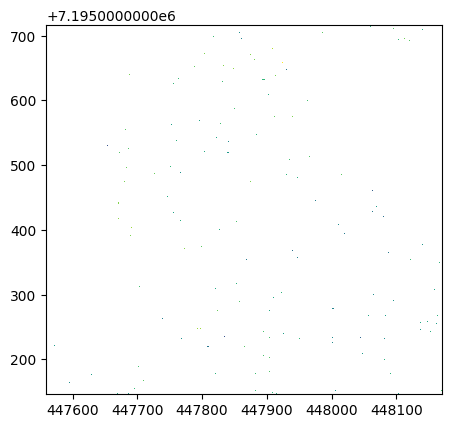

<AxesSubplot:>

In [9]:
#we test focal maxima algorithm
chm_raster = getWebRasterLayer(featlayer[0],chm,"")
chm_qgis = QgsRasterLayer(chm_raster[0], "Your Raster Layer")
print (chm_qgis.rasterUnitsPerPixelX(),chm_qgis.rasterUnitsPerPixelY())
focalMax = focalMaximaCHM(chm_raster[0],4)
focal_qgis = QgsRasterLayer(focalMax, "Your Raster Layer")
print (focal_qgis.rasterUnitsPerPixelX(),focal_qgis.rasterUnitsPerPixelY())
test_raster = rasterio.open(focalMax)
show(test_raster)

In [10]:
def delNulls(input_vector):
    """
    This deletes null-values of treemap  
    """
    input_vector = QgsVectorLayer(input_vector, "puukartta", "ogr")
    

    feats = input_vector.getFeatures()
    dfeat=[]
    
    for feat in feats:
        if feat['CHM'] < 0:
            dfeat.append(feat.id())

    input_vector.dataProvider().deleteFeatures(dfeat)

In [11]:
def createTreeMap(input_chm,distance):
    """
    This creates tree map as point layer from chm raster. Algorithm is based on local maxima at specific search distance
    """
    #tempd = tempfile.TemporaryFile()
    #tempd = tempd.name+'.shp'
    focalMax = focalMaximaCHM(input_chm,distance)
    tempd = processing.run("gdal:polygonize", {'INPUT':focalMax,'BAND':1,'FIELD':'CHM','EIGHT_CONNECTEDNESS':False,'EXTRA':'','OUTPUT':'TEMPORARY_OUTPUT'})
    
    delNulls(tempd['OUTPUT'])
    tempd = processing.run("native:centroids", {'INPUT':tempd['OUTPUT'],'ALL_PARTS':False,'OUTPUT':'TEMPORARY_OUTPUT'})
    processing.run("native:createspatialindex", {'INPUT':tempd['OUTPUT']})

    return tempd['OUTPUT']

In [12]:
#We test chm2treemap conversion
chm_raster = getWebRasterLayer(featlayer[0],chm,"")
treemap = createTreeMap(chm_raster[0],3)

print (treemap.featureCount())

C:\git\smk_tools\processing\getInput.py:170: ResourceWarning: unclosed file <_io.BufferedWriter name='C:\\Users\\mkesala\\AppData\\Local\\Temp\\tmpb5ow0y51.tif'>
  open(tempd,'wb').write(respo.content)


5913


In [13]:
def addFieldValue(in_feat:QgsVectorLayer,fieldname:str,fieldvalue:float):
    """
    This adds field with given value to the vector layer
    """
    fix = processing.run("native:fixgeometries", {'INPUT':in_feat,'OUTPUT':'TEMPORARY_OUTPUT'})
    fix['OUTPUT'].dataProvider().addAttributes([QgsField(fieldname,QVariant.Double)])
    fix['OUTPUT'].updateFields()
    with edit(fix['OUTPUT']):
        for feat in fix['OUTPUT'].getFeatures():
            feat['leimikko']=fieldvalue

            fix['OUTPUT'].updateFeature(feat)
    
    return fix['OUTPUT']

In [15]:
print ([f.name() for f in featlayer[0].fields()])
test = addFieldValue(featlayer[0],"leimikko",1)
print ([f.name() for f in test.fields()])
print (max([f['leimikko'] for f in test.getFeatures()]))

['fid', 'STANDNUMBER']
['fid', 'STANDNUMBER', 'leimikko']
1.0


In [16]:
def joinIntersection(inlayer,joinlayer,joinfields):
    """
    This join by spatial intersection two layers
    """
    joined = processing.run("native:joinattributesbylocation", {'INPUT':inlayer,'JOIN':joinlayer,'PREDICATE':[0],'JOIN_FIELDS':joinfields,'METHOD':0,'DISCARD_NONMATCHING':False,'PREFIX':'','OUTPUT':'TEMPORARY_OUTPUT'})

    return joined['OUTPUT']


In [ ]:
def optimizeRetentioTrees(in_feat:QgsVectorLayer,cutting_area:QgsVectorLayer,protected_area:QgsVectorLayer,treecount:int):
    
    
    in_feat.dataProvider().addAttributes([QgsField("reTree",QVariant.Int)])
    in_feat.updateFields()

    #Rajataan leimikkoon ja poistetaan suojelualueet
    if protected_area is True:
        joinIntersection
    NoLeim = [feat.id() for feat in in_feat.getFeatures() if feat['leimikko']!=1 or feat['OBJECTID'] is not None or feat['SPECIALFEATUREADDITIONALCODE']== 43]
    in_feat.dataProvider().deleteFeatures(NoLeim)
    in_feat.updateFields()

    #if in_feat.featureCount()==0:
    
    #normalizeValue(in_feat,'HS_1')
    opt = np.array([feat['HS_1'] for feat in in_feat.getFeatures()])

    #kopioidaan taso
    #in_feat.selectAll()
    #clone = processing.run("native:saveselectedfeatures",{'INPUT':in_feat,'OUTPUT':'TEMPORARY_OUTPUT'})
    #clone = clone['OUTPUT']
    #in_feat.removeSelection()

    #rajataan
    #OPT = np.array([i[0] for i in arcpy.da.SearchCursor(temp,['OPT_value_HS'][0])])

    treecount = int(round(float(treec) * float(leimArea),0))
    pvalue = opt[np.argsort(opt)[-treecount]]
    #arcpy.CopyFeatures_management(temp,in_feat)
    
    with edit(in_feat):
        for feat in in_feat.getFeatures():
            if feat['HS_1']>=pvalue:
                feat['reTree']=1
            else:
                feat['reTree']=0
            in_feat.updateFeature(feat)
    
    return in_feat
    #noReTree = [feat.id() for feat in in_feat.getFeatures() if feat['HS_1']<pvalue]
    #clone.dataProvider().deleteFeatures(noReTree)